<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/plate_recognizer/notebooks/kaggle_data_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Kaggle license plate dataset

In [275]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/changsin/FSDL

Cloning into 'FSDL'...
remote: Enumerating objects: 825, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 825 (delta 36), reused 43 (delta 26), pack-reused 768
Receiving objects: 100% (825/825), 105.40 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (528/528), done.


In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from importlib.util import find_spec
if find_spec("plate_recognizer") is None:
    import sys
    sys.path.append('..')

In [ ]:
# TODO: creates some incompatibility problems so commenting out for now
# !pip install pytorch_lightning==1.1.4

In [4]:
from FSDL.plate_recognizer.data.kaggle_data import KaggleData
from FSDL.plate_recognizer.data.cluster import Cluster

kaggle_data = KaggleData()
kaggle_data.prepare_data()
kaggle_data.cluster_data(unique=False)
kaggle_data.X.shape

##### log path is /content #####
##### log path is /content #####
##### log path is /content #####


(433, 224, 224, 3)

In [20]:
kaggle_data.partition_on_clusters()

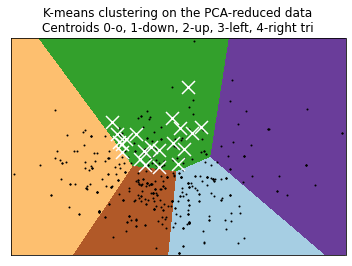

In [21]:
import FSDL.plate_recognizer.utils.plots as plots

plots.plot_data_in_clusters(kaggle_data.X_pca_reduced, kaggle_data.kmeans_pca, kaggle_data.test_idx[1])

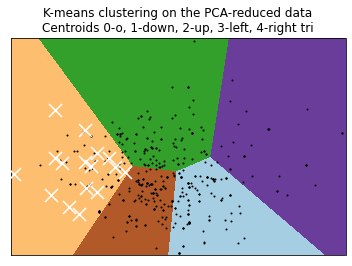

In [22]:
plots.plot_data_in_clusters(kaggle_data.X_pca_reduced, kaggle_data.kmeans_pca, kaggle_data.test_idx[2])

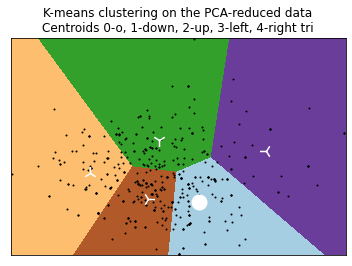

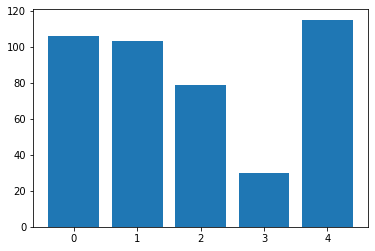

In [24]:
import FSDL.plate_recognizer.utils.plots as plots

K = 5

plots.plot_pca_clusters(kaggle_data.X_pca_reduced, kaggle_data.kmeans_pca)
plots.plot_cluster_histogram(kaggle_data.X_pca_clusters, K)

2021-06-21 05:16:38,083 - FSDL.plate_recognizer.data.cluster - INFO - cluster.py:104 - Found 135 duplicates


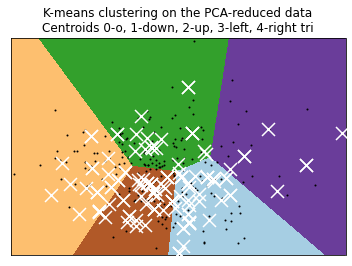

In [25]:
to_remove_idx = Cluster.find_duplicates(kaggle_data.X_pca_reduced)
plots.plot_data_in_clusters(kaggle_data.X_pca_reduced, kaggle_data.kmeans_pca, to_remove_idx)

# Remove duplicate data points

In [26]:
kaggle_data_uniq = KaggleData()
kaggle_data_uniq.prepare_data()
kaggle_data_uniq.cluster_data(K=5, unique=True)

2021-06-21 05:17:23,038 - FSDL.plate_recognizer.data.cluster - INFO - cluster.py:104 - Found 135 duplicates
2021-06-21 05:17:23,039 - FSDL.plate_recognizer.data.kaggle_data - INFO - kaggle_data.py:88 - Removing duplicates 135
2021-06-21 05:17:23,040 - FSDL.plate_recognizer.data.kaggle_data - INFO - kaggle_data.py:92 - Using only 298


In [6]:
def calc_variances(X_pca_reduced):
  # Calculate distances of all points
  distances = cdist(X_pca_reduced, X_pca_reduced)

  # Find duplicates (very similar images)
  # dupes = np.array([np.where(distances[id] < 1) for id in range(distances.shape[0])]).reshape(-1)
  dupes = [np.array(np.where(distances[id] < 1)).reshape(-1).tolist() \
          for id in range(distances.shape[0])]

  to_remove = set()
  for d in dupes:
      if len(d) > 1:
          for id in range(1, len(d)):
              to_remove.add(d[id])
  logger.info("Found {} duplicates".format(len(to_remove)))
  return to_remove

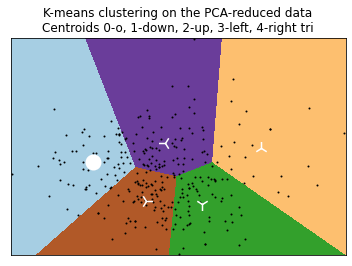

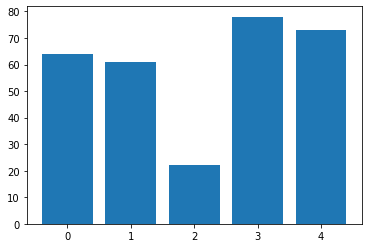

In [27]:
plots.plot_pca_clusters(kaggle_data_uniq.X_pca_reduced, kaggle_data_uniq.kmeans_pca)
plots.plot_cluster_histogram(kaggle_data_uniq.X_pca_clusters, K)

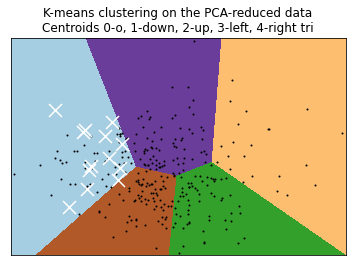

In [29]:
kaggle_data_uniq.partition_on_clusters()

plots.plot_data_in_clusters(kaggle_data_uniq.X_pca_reduced,
                            kaggle_data_uniq.kmeans_pca,
                            kaggle_data_uniq.test_idx[0])

# Weights and Biases

In [30]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.8MB 15.9MB/s 
     |████████████████████████████████| 102kB 11.4MB/s 
     |████████████████████████████████| 174kB 46.2MB/s 
     |████████████████████████████████| 133kB 51.4MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Train

## Train with the full dataset

In [510]:
from FSDL.plate_recognizer.data.base_data_module import DataType
from FSDL.plate_recognizer.models.plate_model import PlateModel
from FSDL.plate_recognizer.training.trainer import Trainer

plate_model = PlateModel()

X_train, Y_train = kaggle_data.get_data(data_type=DataType.Train)
model_cnn = plate_model.create_model(Y_train.shape[0])

trainer = Trainer(model_cnn)
model_cnn = trainer.train(kaggle_data, epochs=100)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
__________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/100
20/20 [==============================] - 3s 66ms/step - loss: 0.0656 - accuracy: 0.4528 - val_loss: 0.0194 - val_accuracy: 0.4737


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 2/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0183 - accuracy: 0.6691 - val_loss: 0.0140 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 3/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0168 - accuracy: 0.6960 - val_loss: 0.0134 - val_accuracy: 0.4474


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 4/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0125 - accuracy: 0.7099 - val_loss: 0.0117 - val_accuracy: 0.6053


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 5/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0085 - accuracy: 0.8099 - val_loss: 0.0106 - val_accuracy: 0.6053


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 6/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0072 - accuracy: 0.7659 - val_loss: 0.0094 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 7/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0058 - accuracy: 0.8105 - val_loss: 0.0091 - val_accuracy: 0.6053


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 8/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0051 - accuracy: 0.8123 - val_loss: 0.0065 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 9/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0044 - accuracy: 0.8133 - val_loss: 0.0062 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 10/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0048 - accuracy: 0.7887 - val_loss: 0.0056 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 11/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0038 - accuracy: 0.8826 - val_loss: 0.0058 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 12/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0037 - accuracy: 0.8130 - val_loss: 0.0065 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 13/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0035 - accuracy: 0.8478 - val_loss: 0.0086 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 14/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0043 - accuracy: 0.8494 - val_loss: 0.0065 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 15/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0044 - accuracy: 0.8568 - val_loss: 0.0060 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 16/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0033 - accuracy: 0.8395 - val_loss: 0.0056 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 17/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0031 - accuracy: 0.8599 - val_loss: 0.0061 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 18/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0032 - accuracy: 0.8653 - val_loss: 0.0062 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 19/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0027 - accuracy: 0.8602 - val_loss: 0.0049 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 20/100
20/20 [==============================] - 0s 25ms/step - loss: 0.0027 - accuracy: 0.8738 - val_loss: 0.0059 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 21/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0032 - accuracy: 0.8862 - val_loss: 0.0057 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 22/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0029 - accuracy: 0.8897 - val_loss: 0.0053 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 23/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0025 - accuracy: 0.9040 - val_loss: 0.0062 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 24/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0025 - accuracy: 0.8576 - val_loss: 0.0066 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 25/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0024 - accuracy: 0.8812 - val_loss: 0.0054 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 26/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0021 - accuracy: 0.8617 - val_loss: 0.0048 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 27/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0023 - accuracy: 0.8678 - val_loss: 0.0049 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 28/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0020 - accuracy: 0.8869 - val_loss: 0.0046 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 29/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0023 - accuracy: 0.8555 - val_loss: 0.0061 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 30/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0023 - accuracy: 0.8816 - val_loss: 0.0052 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 31/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0024 - accuracy: 0.8526 - val_loss: 0.0046 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 32/100
20/20 [==============================] - 1s 25ms/step - loss: 0.0020 - accuracy: 0.8861 - val_loss: 0.0044 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 33/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0021 - accuracy: 0.8774 - val_loss: 0.0049 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 34/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0021 - accuracy: 0.8761 - val_loss: 0.0047 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 35/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0023 - accuracy: 0.9113 - val_loss: 0.0058 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 36/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0019 - accuracy: 0.9100 - val_loss: 0.0051 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 37/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0020 - accuracy: 0.8860 - val_loss: 0.0049 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 38/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0018 - accuracy: 0.9117 - val_loss: 0.0042 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 39/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0020 - accuracy: 0.8952 - val_loss: 0.0051 - val_accuracy: 0.5789


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 40/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0021 - accuracy: 0.9031 - val_loss: 0.0044 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 41/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0022 - accuracy: 0.9100 - val_loss: 0.0053 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 42/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0015 - accuracy: 0.8939 - val_loss: 0.0049 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 43/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0016 - accuracy: 0.9051 - val_loss: 0.0041 - val_accuracy: 0.8421


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 44/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0015 - accuracy: 0.8931 - val_loss: 0.0048 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 45/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0014 - accuracy: 0.9145 - val_loss: 0.0043 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 46/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0015 - accuracy: 0.9268 - val_loss: 0.0040 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 47/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0014 - accuracy: 0.8983 - val_loss: 0.0049 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 48/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0014 - accuracy: 0.8900 - val_loss: 0.0042 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 49/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0016 - accuracy: 0.9151 - val_loss: 0.0043 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 50/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0015 - accuracy: 0.8848 - val_loss: 0.0043 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 51/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0014 - accuracy: 0.9041 - val_loss: 0.0049 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 52/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0015 - accuracy: 0.8810 - val_loss: 0.0041 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 53/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0013 - accuracy: 0.9170 - val_loss: 0.0038 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 54/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0015 - accuracy: 0.8990 - val_loss: 0.0046 - val_accuracy: 0.6053


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 55/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0014 - accuracy: 0.8694 - val_loss: 0.0044 - val_accuracy: 0.8158


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 56/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0014 - accuracy: 0.8944 - val_loss: 0.0042 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 57/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0015 - accuracy: 0.8916 - val_loss: 0.0045 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 58/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0012 - accuracy: 0.9275 - val_loss: 0.0044 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 59/100
20/20 [==============================] - 1s 25ms/step - loss: 0.0016 - accuracy: 0.8722 - val_loss: 0.0037 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 60/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0012 - accuracy: 0.9099 - val_loss: 0.0036 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 61/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0012 - accuracy: 0.9277 - val_loss: 0.0041 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 62/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0013 - accuracy: 0.9170 - val_loss: 0.0044 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 63/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0013 - accuracy: 0.9118 - val_loss: 0.0046 - val_accuracy: 0.8158


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 64/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0013 - accuracy: 0.9107 - val_loss: 0.0049 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 65/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0013 - accuracy: 0.8994 - val_loss: 0.0042 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 66/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0011 - accuracy: 0.9339 - val_loss: 0.0037 - val_accuracy: 0.8158


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 67/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0014 - accuracy: 0.8880 - val_loss: 0.0036 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 68/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0012 - accuracy: 0.9091 - val_loss: 0.0035 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 69/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0012 - accuracy: 0.9320 - val_loss: 0.0041 - val_accuracy: 0.8158


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 70/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0012 - accuracy: 0.8892 - val_loss: 0.0040 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 71/100
20/20 [==============================] - 1s 28ms/step - loss: 0.0011 - accuracy: 0.9271 - val_loss: 0.0036 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 72/100
20/20 [==============================] - 1s 28ms/step - loss: 0.0011 - accuracy: 0.9353 - val_loss: 0.0040 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 73/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0011 - accuracy: 0.9241 - val_loss: 0.0034 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 74/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0011 - accuracy: 0.9392 - val_loss: 0.0040 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 75/100
20/20 [==============================] - 1s 28ms/step - loss: 9.7944e-04 - accuracy: 0.8995 - val_loss: 0.0037 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 76/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0011 - accuracy: 0.9238 - val_loss: 0.0043 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 77/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0010 - accuracy: 0.9305 - val_loss: 0.0046 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 78/100
20/20 [==============================] - 1s 25ms/step - loss: 0.0012 - accuracy: 0.9447 - val_loss: 0.0037 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 79/100
20/20 [==============================] - 1s 26ms/step - loss: 8.6122e-04 - accuracy: 0.9467 - val_loss: 0.0039 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 80/100
20/20 [==============================] - 1s 26ms/step - loss: 8.9690e-04 - accuracy: 0.9252 - val_loss: 0.0036 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 81/100
20/20 [==============================] - 1s 26ms/step - loss: 9.7889e-04 - accuracy: 0.9447 - val_loss: 0.0039 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 82/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0010 - accuracy: 0.9241 - val_loss: 0.0039 - val_accuracy: 0.8421


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 83/100
20/20 [==============================] - 1s 26ms/step - loss: 9.8370e-04 - accuracy: 0.8951 - val_loss: 0.0035 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 84/100
20/20 [==============================] - 1s 26ms/step - loss: 8.5916e-04 - accuracy: 0.9335 - val_loss: 0.0035 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 85/100
20/20 [==============================] - 1s 26ms/step - loss: 8.2280e-04 - accuracy: 0.9240 - val_loss: 0.0038 - val_accuracy: 0.8421


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 86/100
20/20 [==============================] - 1s 26ms/step - loss: 9.2774e-04 - accuracy: 0.9405 - val_loss: 0.0033 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 87/100
20/20 [==============================] - 1s 26ms/step - loss: 9.3919e-04 - accuracy: 0.9099 - val_loss: 0.0042 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 88/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0012 - accuracy: 0.8961 - val_loss: 0.0032 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 89/100
20/20 [==============================] - 1s 26ms/step - loss: 9.6312e-04 - accuracy: 0.9080 - val_loss: 0.0034 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 90/100
20/20 [==============================] - 1s 26ms/step - loss: 9.0753e-04 - accuracy: 0.9253 - val_loss: 0.0046 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 91/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0012 - accuracy: 0.9053 - val_loss: 0.0038 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 92/100
20/20 [==============================] - 1s 26ms/step - loss: 9.6971e-04 - accuracy: 0.9291 - val_loss: 0.0043 - val_accuracy: 0.8158


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 93/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0010 - accuracy: 0.9154 - val_loss: 0.0038 - val_accuracy: 0.8158


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 94/100
20/20 [==============================] - 1s 26ms/step - loss: 7.9491e-04 - accuracy: 0.9299 - val_loss: 0.0040 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 95/100
20/20 [==============================] - 1s 26ms/step - loss: 9.9548e-04 - accuracy: 0.9219 - val_loss: 0.0039 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 96/100
20/20 [==============================] - 1s 26ms/step - loss: 9.0405e-04 - accuracy: 0.9231 - val_loss: 0.0033 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 97/100
20/20 [==============================] - 1s 26ms/step - loss: 8.1618e-04 - accuracy: 0.9226 - val_loss: 0.0037 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 98/100
20/20 [==============================] - 1s 26ms/step - loss: 9.0281e-04 - accuracy: 0.9392 - val_loss: 0.0037 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 99/100
20/20 [==============================] - 1s 26ms/step - loss: 8.4929e-04 - accuracy: 0.9240 - val_loss: 0.0040 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 100/100
20/20 [==============================] - 1s 26ms/step - loss: 8.4507e-04 - accuracy: 0.9380 - val_loss: 0.0042 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


2021-06-21 14:46:19,149 - FSDL.plate_recognizer.training.trainer - INFO - trainer.py:37 - Score : 79.55%
100/100 [==============================] - 1s 4ms/step - loss: 0.0075 - accuracy: 0.7955
2021-06-21 14:46:20,321 - FSDL.plate_recognizer.training.trainer - INFO - trainer.py:41 - Test results 
 Loss: 0.0075295851565897465
 Accuracy: 0.7954545617103577


## Train with unique data points

With the duplicate data points removed, the model train much faster and better accuracy 78% -> 92%

In [511]:
from FSDL.plate_recognizer.data.base_data_module import DataType
from FSDL.plate_recognizer.models.plate_model import PlateModel
from FSDL.plate_recognizer.training.trainer import Trainer

plate_model_uniq = PlateModel()

X_train_uniq, Y_train_uniq = kaggle_data_uniq.get_data(data_type=DataType.Train)
model_cnn_uniq = plate_model_uniq.create_model(Y_train_uniq.shape[0])

trainer_uniq = Trainer(model_cnn_uniq, name="Trained on unique data points")
model_cnn_uniq = trainer_uniq.train(kaggle_data_uniq, epochs=100)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
__________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/100
14/14 [==============================] - 3s 82ms/step - loss: 0.0640 - accuracy: 0.4726 - val_loss: 0.0301 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 2/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0332 - accuracy: 0.5858 - val_loss: 0.0212 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 3/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0204 - accuracy: 0.6964 - val_loss: 0.0132 - val_accuracy: 0.6154


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 4/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0147 - accuracy: 0.7226 - val_loss: 0.0102 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 5/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0128 - accuracy: 0.8156 - val_loss: 0.0106 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 6/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0103 - accuracy: 0.8022 - val_loss: 0.0100 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 7/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0103 - accuracy: 0.7236 - val_loss: 0.0102 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 8/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0066 - accuracy: 0.8188 - val_loss: 0.0102 - val_accuracy: 0.6538


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 9/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0075 - accuracy: 0.8363 - val_loss: 0.0085 - val_accuracy: 0.6154


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 10/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0071 - accuracy: 0.8177 - val_loss: 0.0094 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 11/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0073 - accuracy: 0.8358 - val_loss: 0.0085 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 12/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0049 - accuracy: 0.8099 - val_loss: 0.0086 - val_accuracy: 0.6538


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 13/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0049 - accuracy: 0.8467 - val_loss: 0.0078 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 14/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0049 - accuracy: 0.8434 - val_loss: 0.0117 - val_accuracy: 0.5769


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 15/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0068 - accuracy: 0.8562 - val_loss: 0.0064 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 16/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0044 - accuracy: 0.8742 - val_loss: 0.0073 - val_accuracy: 0.5385


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 17/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0041 - accuracy: 0.8249 - val_loss: 0.0077 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 18/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0043 - accuracy: 0.7686 - val_loss: 0.0073 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 19/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0044 - accuracy: 0.8255 - val_loss: 0.0065 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 20/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0032 - accuracy: 0.8417 - val_loss: 0.0083 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 21/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0037 - accuracy: 0.8322 - val_loss: 0.0074 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 22/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0041 - accuracy: 0.8669 - val_loss: 0.0069 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 23/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0039 - accuracy: 0.8269 - val_loss: 0.0079 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 24/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0038 - accuracy: 0.8712 - val_loss: 0.0062 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 25/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0036 - accuracy: 0.8538 - val_loss: 0.0072 - val_accuracy: 0.6538


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 26/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0035 - accuracy: 0.8350 - val_loss: 0.0063 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 27/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0028 - accuracy: 0.8825 - val_loss: 0.0068 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 28/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0029 - accuracy: 0.8971 - val_loss: 0.0063 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 29/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0032 - accuracy: 0.8542 - val_loss: 0.0061 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 30/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0030 - accuracy: 0.8863 - val_loss: 0.0054 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 31/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0030 - accuracy: 0.8481 - val_loss: 0.0065 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 32/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0026 - accuracy: 0.9004 - val_loss: 0.0056 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 33/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0024 - accuracy: 0.8596 - val_loss: 0.0063 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 34/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0026 - accuracy: 0.8491 - val_loss: 0.0055 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 35/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0024 - accuracy: 0.9049 - val_loss: 0.0068 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 36/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0026 - accuracy: 0.8946 - val_loss: 0.0056 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 37/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 0.9085 - val_loss: 0.0065 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 38/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.8933 - val_loss: 0.0062 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 39/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0024 - accuracy: 0.8911 - val_loss: 0.0070 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 40/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0021 - accuracy: 0.8895 - val_loss: 0.0057 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 41/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0026 - accuracy: 0.8618 - val_loss: 0.0049 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 42/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0019 - accuracy: 0.9366 - val_loss: 0.0054 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 43/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.9158 - val_loss: 0.0059 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 44/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0019 - accuracy: 0.9067 - val_loss: 0.0053 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 45/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 0.9309 - val_loss: 0.0052 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 46/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 0.9063 - val_loss: 0.0053 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 47/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0019 - accuracy: 0.8991 - val_loss: 0.0047 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 48/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 0.8962 - val_loss: 0.0053 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 49/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0017 - accuracy: 0.9234 - val_loss: 0.0060 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 50/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 0.9004 - val_loss: 0.0054 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 51/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0017 - accuracy: 0.9036 - val_loss: 0.0054 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 52/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0017 - accuracy: 0.9175 - val_loss: 0.0051 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 53/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0016 - accuracy: 0.8840 - val_loss: 0.0053 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 54/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0019 - accuracy: 0.8927 - val_loss: 0.0052 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 55/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0023 - accuracy: 0.9010 - val_loss: 0.0053 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 56/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.9052 - val_loss: 0.0048 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 57/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0021 - accuracy: 0.8744 - val_loss: 0.0057 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 58/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.9289 - val_loss: 0.0055 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 59/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.9450 - val_loss: 0.0055 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 60/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0015 - accuracy: 0.9199 - val_loss: 0.0053 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 61/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 0.9191 - val_loss: 0.0050 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 62/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0019 - accuracy: 0.8712 - val_loss: 0.0058 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 63/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0024 - accuracy: 0.8623 - val_loss: 0.0053 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 64/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.8922 - val_loss: 0.0052 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 65/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 0.8579 - val_loss: 0.0052 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 66/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0013 - accuracy: 0.9337 - val_loss: 0.0052 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 67/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0014 - accuracy: 0.9425 - val_loss: 0.0055 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 68/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0013 - accuracy: 0.9376 - val_loss: 0.0047 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 69/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0014 - accuracy: 0.9231 - val_loss: 0.0051 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 70/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0015 - accuracy: 0.8547 - val_loss: 0.0058 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 71/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0014 - accuracy: 0.9224 - val_loss: 0.0057 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 72/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0014 - accuracy: 0.8738 - val_loss: 0.0052 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 73/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0015 - accuracy: 0.9368 - val_loss: 0.0055 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 74/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0014 - accuracy: 0.8929 - val_loss: 0.0051 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 75/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0014 - accuracy: 0.8726 - val_loss: 0.0047 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 76/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 0.8923 - val_loss: 0.0048 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 77/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0016 - accuracy: 0.8915 - val_loss: 0.0043 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 78/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0019 - accuracy: 0.8666 - val_loss: 0.0061 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 79/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0019 - accuracy: 0.8822 - val_loss: 0.0048 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 80/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0019 - accuracy: 0.9301 - val_loss: 0.0045 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 81/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0014 - accuracy: 0.9014 - val_loss: 0.0046 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 82/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0011 - accuracy: 0.9537 - val_loss: 0.0046 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 83/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 0.9297 - val_loss: 0.0053 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 84/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 0.9326 - val_loss: 0.0048 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 85/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 0.9091 - val_loss: 0.0048 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 86/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0013 - accuracy: 0.8766 - val_loss: 0.0050 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 87/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 0.9277 - val_loss: 0.0047 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 88/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 0.9063 - val_loss: 0.0049 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 89/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 0.9283 - val_loss: 0.0054 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 90/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0011 - accuracy: 0.9478 - val_loss: 0.0038 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 91/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0011 - accuracy: 0.9770 - val_loss: 0.0052 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 92/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0010 - accuracy: 0.9693 - val_loss: 0.0046 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 93/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0010 - accuracy: 0.9455 - val_loss: 0.0047 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 94/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0013 - accuracy: 0.9495 - val_loss: 0.0041 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 95/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0011 - accuracy: 0.9461 - val_loss: 0.0041 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 96/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 0.9087 - val_loss: 0.0046 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 97/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0011 - accuracy: 0.8939 - val_loss: 0.0049 - val_accuracy: 0.8846


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 98/100
14/14 [==============================] - 0s 28ms/step - loss: 0.0011 - accuracy: 0.9475 - val_loss: 0.0045 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 99/100
14/14 [==============================] - 0s 28ms/step - loss: 0.0012 - accuracy: 0.8949 - val_loss: 0.0042 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 100/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0012 - accuracy: 0.9453 - val_loss: 0.0047 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


2021-06-21 14:47:11,330 - FSDL.plate_recognizer.training.trainer - INFO - trainer.py:37 - Score : 72.58%
100/100 [==============================] - 1s 4ms/step - loss: 0.0109 - accuracy: 0.6774
2021-06-21 14:47:12,792 - FSDL.plate_recognizer.training.trainer - INFO - trainer.py:41 - Test results 
 Loss: 0.010888314805924892
 Accuracy: 0.6774193644523621


# Predictions

Predict on both models


In [512]:
import FSDL.plate_recognizer.training.predictor as predictor

stats = predictor.predict_on_models(kaggle_data, range(K),
                                    [model_cnn, model_cnn_uniq],
                                    iterations=50, iou_threshold=0.5)

1/1 [==============================] - 1s 747ms/step - loss: 0.0026 - accuracy: 0.5455
2021-06-21 14:47:58,394 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 0 mAP: 0.26 std: 0.02 acc: 0.55
1/1 [==============================] - 0s 47ms/step - loss: 0.0092 - accuracy: 0.7619
2021-06-21 14:48:01,243 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 1 mAP: 0.10 std: 0.02 acc: 0.76
1/1 [==============================] - 0s 36ms/step - loss: 0.0206 - accuracy: 0.6875
2021-06-21 14:48:03,357 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 2 mAP: 0.03 std: 0.02 acc: 0.69
1/1 [==============================] - 0s 29ms/step - loss: 0.0052 - accuracy: 1.0000
2021-06-21 14:48:04,612 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 3 mAP: 0.24 std: 0.02 acc: 1.00
1/1 [==============================] - 0s 49ms/step - loss: 0.0024 - accuracy: 0.8696
2021-06-21 14:48:07,620 - FSDL.plate_recognizer.training.predicto

In [513]:
stats_uniq = predictor.predict_on_models(kaggle_data_uniq, range(K),
                                         [model_cnn, model_cnn_uniq],
                                         iterations=50, iou_threshold=0.5)

1/1 [==============================] - 0s 32ms/step - loss: 0.0014 - accuracy: 1.0000
2021-06-21 14:48:22,491 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 0 mAP: 0.50 std: 0.02 acc: 1.00
1/1 [==============================] - 0s 35ms/step - loss: 0.0038 - accuracy: 0.6154
2021-06-21 14:48:24,402 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 1 mAP: 0.68 std: 0.02 acc: 0.62
1/1 [==============================] - 0s 24ms/step - loss: 0.0061 - accuracy: 0.8000
2021-06-21 14:48:25,496 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 2 mAP: 0.02 std: 0.02 acc: 0.80
1/1 [==============================] - 0s 35ms/step - loss: 0.0015 - accuracy: 0.8750
2021-06-21 14:48:27,613 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 3 mAP: 0.28 std: 0.02 acc: 0.88
1/1 [==============================] - 0s 37ms/step - loss: 0.0032 - accuracy: 0.7333
2021-06-21 14:48:29,701 - FSDL.plate_recognizer.training.predictor

Compare the results. Standard deviations first. It does not show any statistical differences.

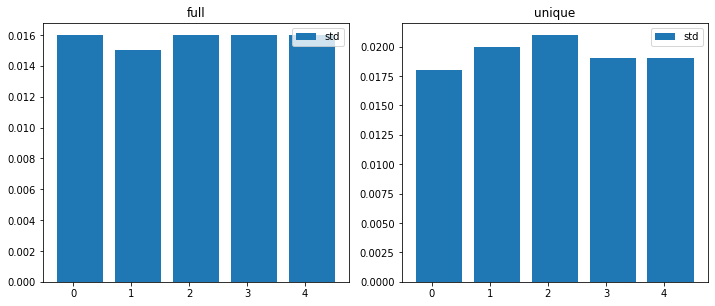

In [514]:
import FSDL.plate_recognizer.utils.plots as plots

titles = ["full", "unique"]
plots.plot_stats(stats, ["std"], titles)

mAP is showing a little bit worse result for the unique dataset. Perhaps it is because the dataset is too small.

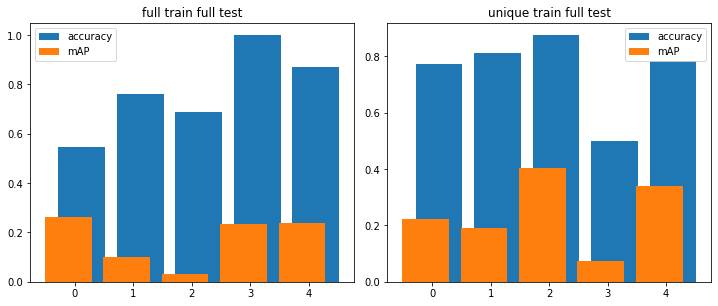

In [515]:
titles = ["full train full test", "unique train full test"]
plots.plot_stats(stats, ["accuracy", "mAP"], titles)

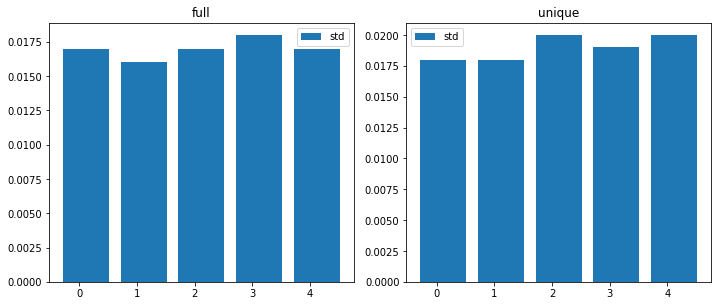

In [516]:
titles = ["full", "unique"]
plots.plot_stats(stats_uniq, ["std"], titles)

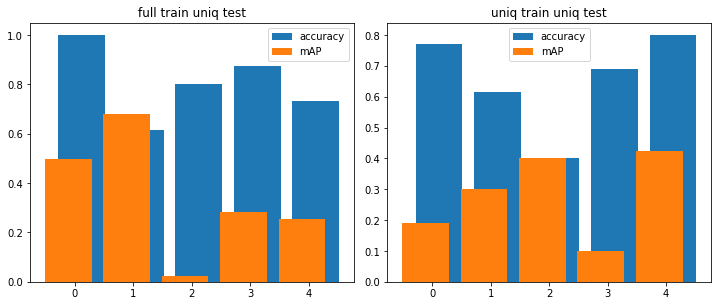

In [517]:
titles = ["full train uniq test", "uniq train uniq test"]
plots.plot_stats(stats_uniq, ["accuracy", "mAP"], titles)

In [527]:
 [m.mean() for m in stats_uniq[..., 0]]

[0.3484000016003847, 0.2828000023961067]

In [528]:
 [m.mean() for m in stats[..., 0]]

[0.17479999884963035, 0.24560000002384186]

1/1 [==============================] - 0s 37ms/step - loss: 0.0099 - accuracy: 0.7692


tensor(0.3483)

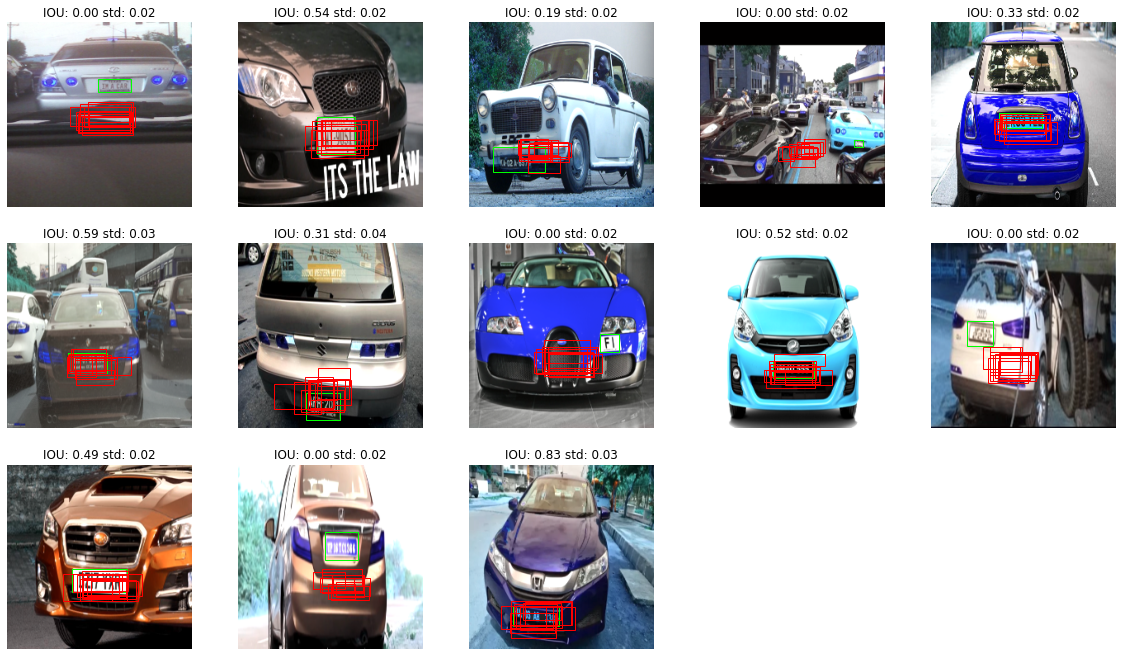

In [266]:
X_test_uniq, Y_test_uniq = kaggle_data_uniq.get_data(data_type=DataType.Test, cluster_id=0)

y_preds_uniq, m_ap_uniq, mstd_uniq, accuracy_uniq = \
  predictor.predict_on_cluster(model_cnn_uniq, X_test_uniq, Y_test_uniq, iterations=10)
plots.plot_predictions(X_test_uniq, Y_test_uniq, y_preds_uniq)
m_ap_uniq

1/1 [==============================] - 0s 51ms/step - loss: 0.0030 - accuracy: 0.7273


tensor(0.3718)

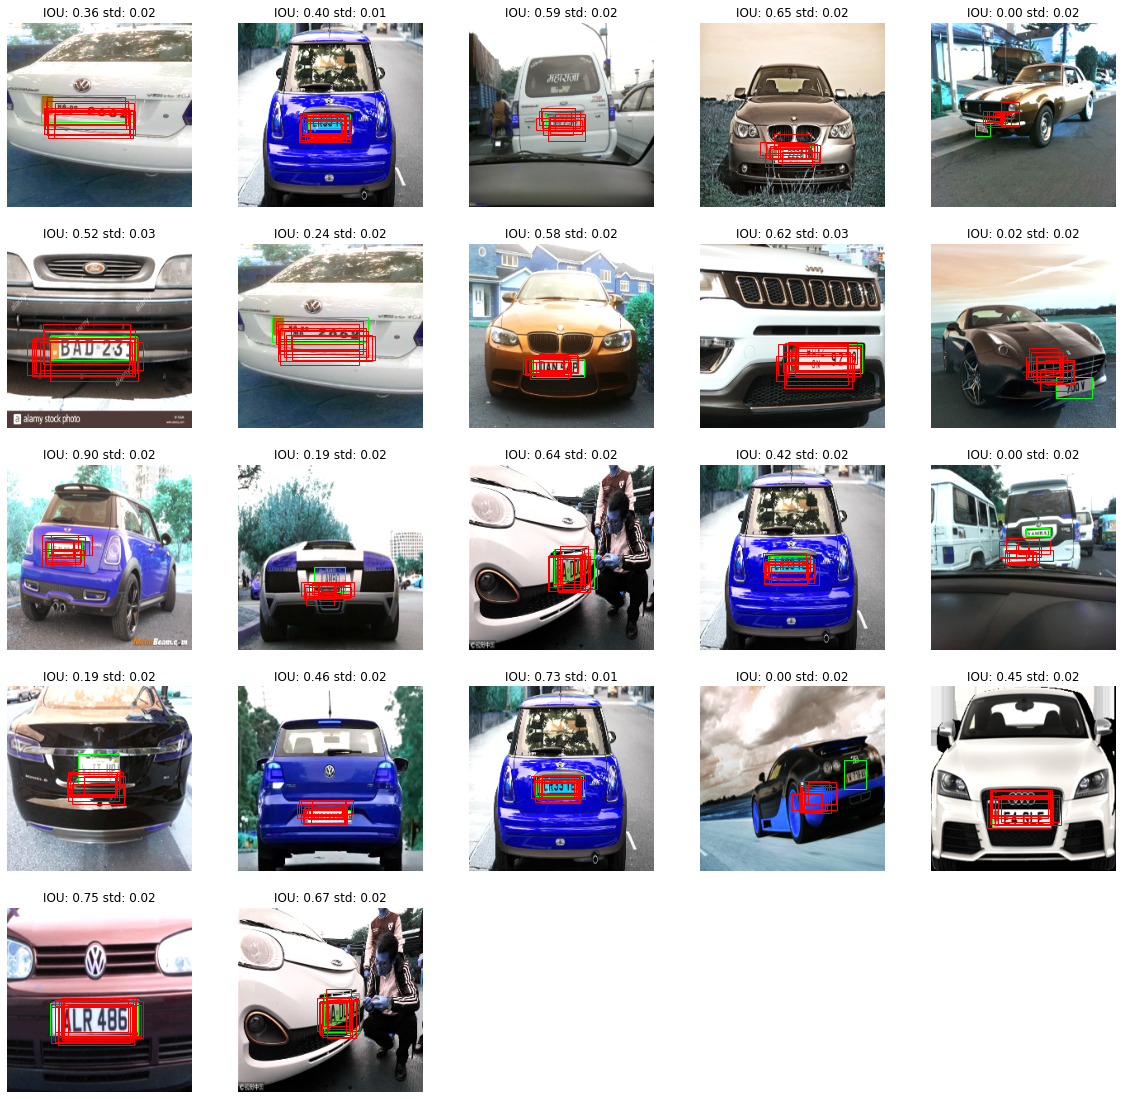

In [268]:
X_test, Y_test = kaggle_data.get_data(data_type=DataType.Test, cluster_id=0)

y_preds, m_ap, mstd, accuracy = \
  predictor.predict_on_cluster(model_cnn, X_test, Y_test, iterations=10)
plots.plot_predictions(X_test, Y_test, y_preds)
m_ap

1/1 [==============================] - 0s 38ms/step - loss: 0.0017 - accuracy: 1.0000


tensor(0.3846)

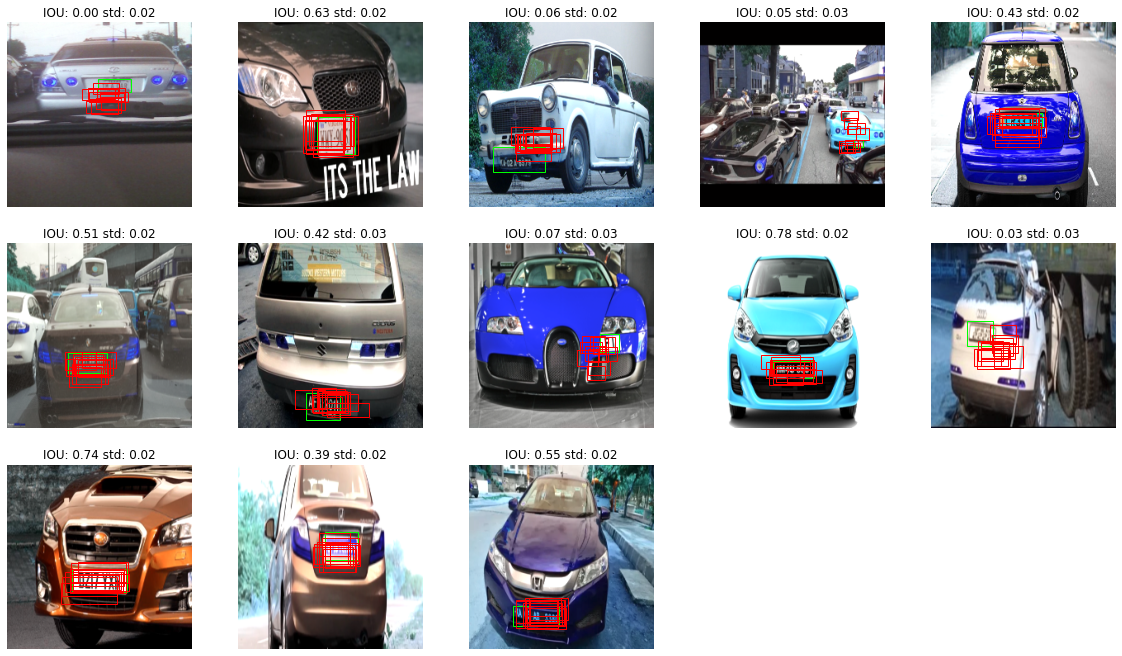

In [270]:
y_preds, m_ap, mstd, accuracy = \
  predictor.predict_on_cluster(model_cnn, X_test_uniq, Y_test_uniq, iterations=10)
plots.plot_predictions(X_test_uniq, Y_test_uniq, y_preds)
m_ap

1/1 [==============================] - 3s 3s/step - loss: 0.0031 - accuracy: 0.7742


tensor(0.3440)

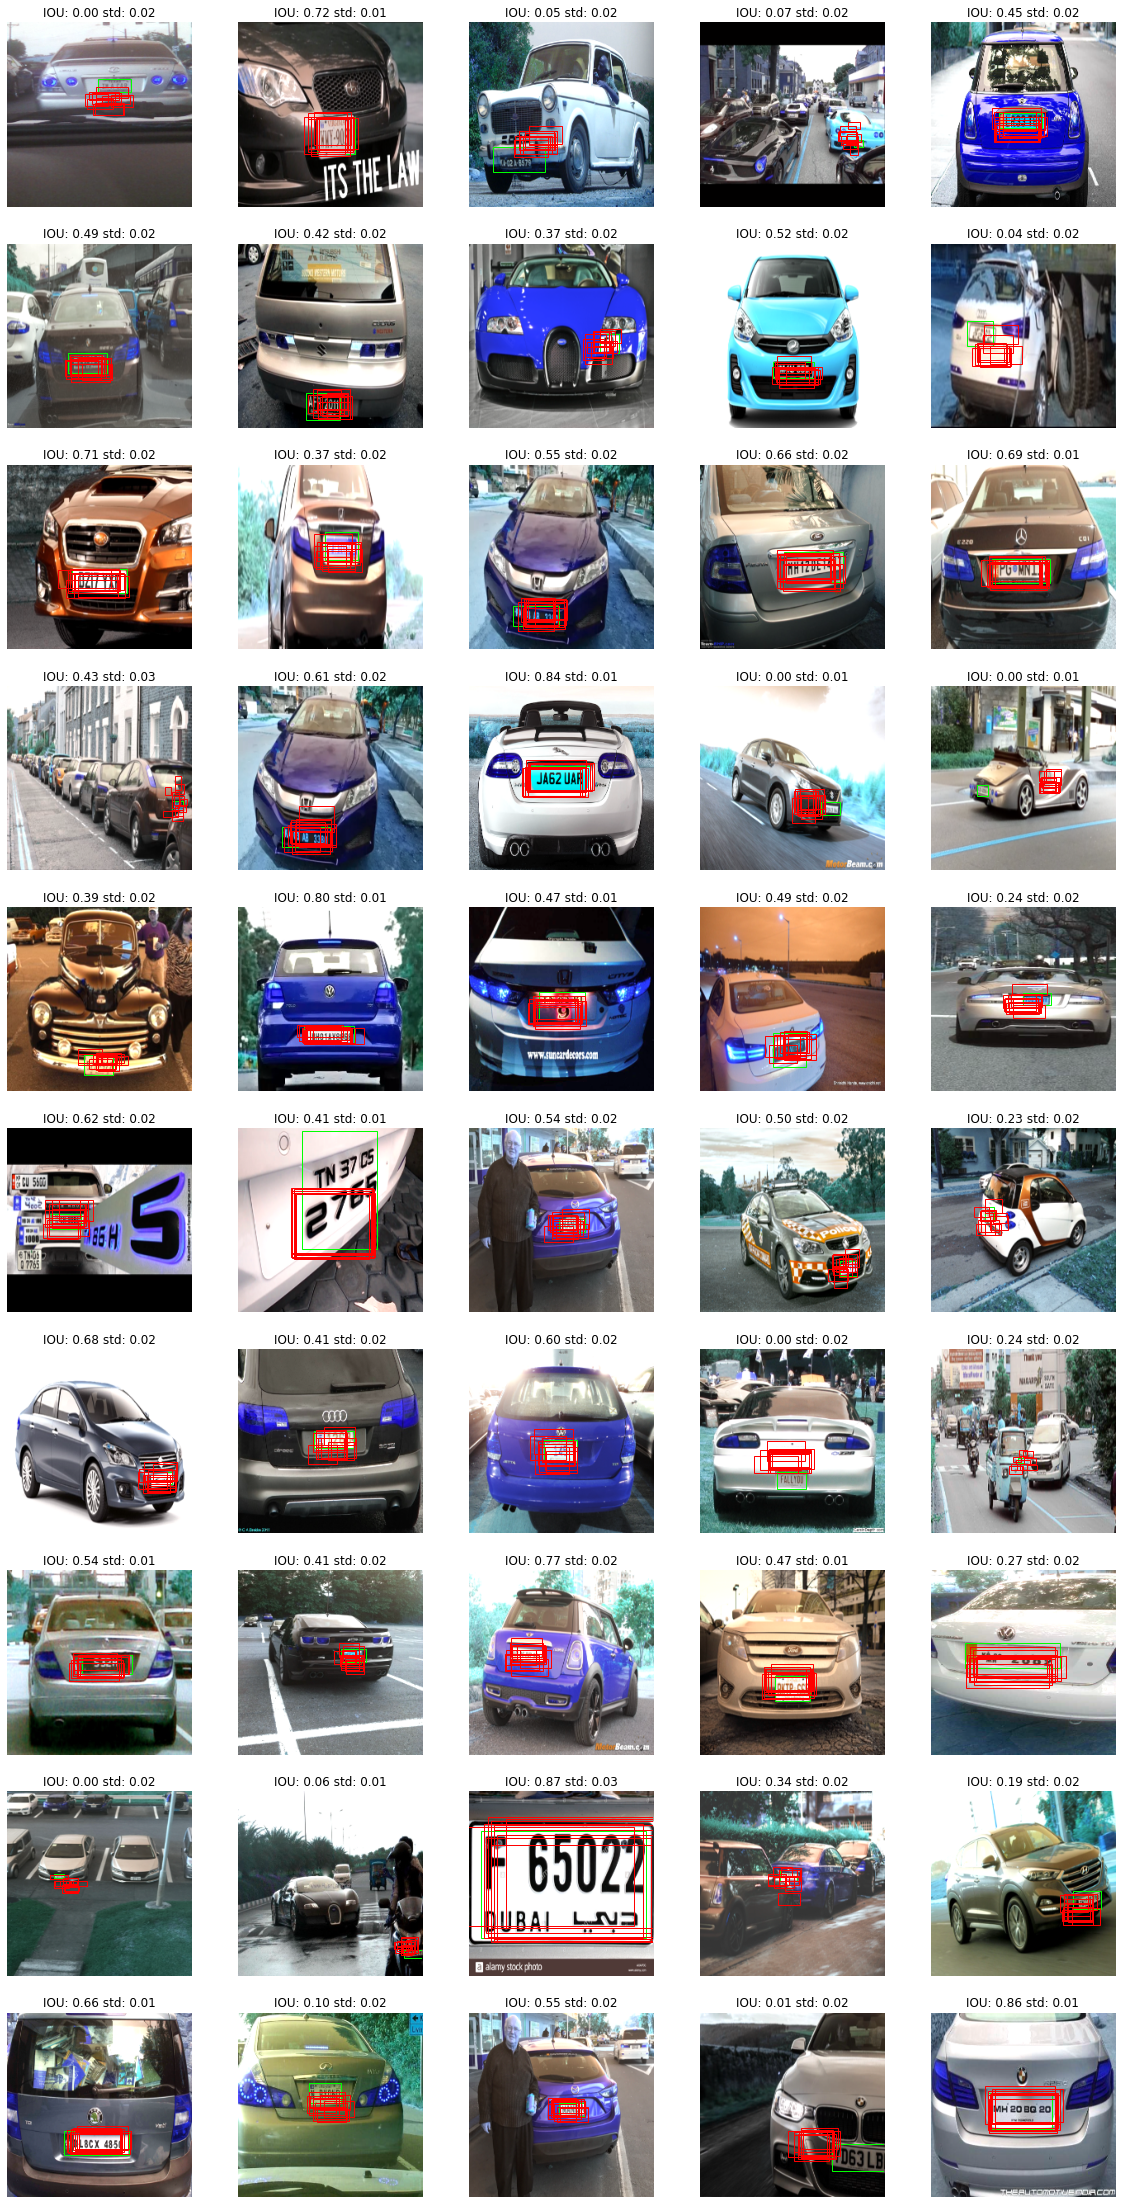

In [287]:
X_test_uniq, Y_test_uniq = kaggle_data_uniq.get_data(data_type=DataType.Test)


y_preds, m_ap, mstd, accuracy = \
  predictor.predict_on_cluster(model_cnn, X_test_uniq, Y_test_uniq, iterations=10)
plots.plot_predictions(X_test_uniq, Y_test_uniq, y_preds)
m_ap

In [504]:
y_preds_avg = predictor.average_sample_preds(y_preds)
map = metrics.mean_average_precision(Y_test_uniq, y_preds_avg)


In [505]:
map

tensor(0.1718)

In [506]:
metrics.mean_average_precision(Y_test_uniq[:40], np.vstack((Y_test_uniq[:30], np.zeros([10, 4]))), iou_threshold=0.5)

tensor(0.7500)